## Compare LightGBM in the case of binary class (Sell, Buy)

In [ ]:
import sys
from pathlib import Path

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)

In [ ]:
from utility_functions import (
    backtest_strategy,
    display_report,
    plot_feature_imp,
    plot_strategy,
    select_threshold,
    tune_params,
)

In [1]:
import warnings

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

warnings.filterwarnings("ignore")

In [2]:
METRIC = "average_precision"
FPR_MAX = 0.01
TEST_SIZE = 350
TIMEOUT = 600

In [3]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [4]:
target = pd.read_csv("../data/processed/target_df.csv", parse_dates=True, index_col=0)[
    "target"
]

In [5]:
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [6]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [7]:
interest_rate = wk_df["r"].values

## Control LightGBM Classifier without new data

In [8]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

### Split dataset

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df,
    target.values.flatten(),
    test_size=TEST_SIZE,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [10]:
params = tune_params(X_train, y_train, METRIC, TIMEOUT, max_iter=35, max_dep=12)

[I 2024-02-18 23:50:46,714] A new study created in memory with name: no-name-c0e4ceae-c109-48f6-a734-ecf18e69b007


[I 2024-02-18 23:50:47,382] Trial 0 finished with value: 0.49515929981410844 and parameters: {'n_estimators': 20, 'lambda_l1': 0.0026568795174116543, 'lambda_l2': 5.691357779832114, 'num_leaves': 51, 'min_sum_hessian_in_leaf': 3.06251108704905, 'feature_fraction': 0.700901728913941, 'feature_fraction_bynode': 0.40951542213203884, 'bagging_fraction': 0.4510358790928265, 'bagging_freq': 6, 'min_child_samples': 80, 'num_grad_quant_bins': 6, 'max_depth': 6, 'extra_trees': True}. Best is trial 0 with value: 0.49515929981410844.
[I 2024-02-18 23:50:47,599] Trial 1 finished with value: 0.5296422827077284 and parameters: {'n_estimators': 20, 'lambda_l1': 0.001149913335423407, 'lambda_l2': 17.663118301499786, 'num_leaves': 33, 'min_sum_hessian_in_leaf': 6.191357356715355, 'feature_fraction': 0.688325844495046, 'feature_fraction_bynode': 0.39313322880424395, 'bagging_fraction': 0.43045508715218006, 'bagging_freq': 6, 'min_child_samples': 81, 'num_grad_quant_bins': 6, 'max_depth': 6, 'extra_trees

Number of finished trials: 150
Best trial:
  Number: 24
  Value: 0.6702045308954394
  Params: 
    n_estimators: 20
    lambda_l1: 1.0075418914792277e-05
    lambda_l2: 0.4609218380361685
    num_leaves: 237
    min_sum_hessian_in_leaf: 9.121313078181301e-06
    feature_fraction: 0.987599194799673
    feature_fraction_bynode: 0.5062272039181832
    bagging_fraction: 0.8017724667702772
    bagging_freq: 5
    min_child_samples: 13
    num_grad_quant_bins: 9
    max_depth: 12
    extra_trees: False


In [11]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "clf",
            lgb.LGBMClassifier(
                **params
                | {
                    "random_state": 1968,
                    "objective": "binary",
                    "metric": METRIC,
                    "verbosity": -1,
                    "boosting_type": "gbdt",
                }
            ),
        ),
    ]
)

In [12]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('clf',
                 LGBMClassifier(bagging_fraction=0.8017724667702772,
                                bagging_freq=5, extra_trees=False,
                                feature_fraction=0.987599194799673,
                                feature_fraction_bynode=0.5062272039181832,
                                lambda_l1=1.0075418914792277e-05,
                                lambda_l2=0.4609218380361685, max_depth=12,
                                metric='average_precision',
                                min_child_samples=13,
                                min_sum_hessian_in_leaf=9.121313078181301e-06,
                                n_estimators=20, num_grad_quant_bins=9,
                                num_leaves=237, objective='binary',
                                random_state=1968, verbosity=-1))])

In [13]:
# In-sample score
pipe.score(X_train, y_train)

0.8652849740932642

In [14]:
in_sample_preds = pipe.predict(X_train)

              precision    recall  f1-score   support

           0       0.87      0.86      0.87       582
           1       0.86      0.87      0.87       576

    accuracy                           0.87      1158
   macro avg       0.87      0.87      0.87      1158
weighted avg       0.87      0.87      0.87      1158



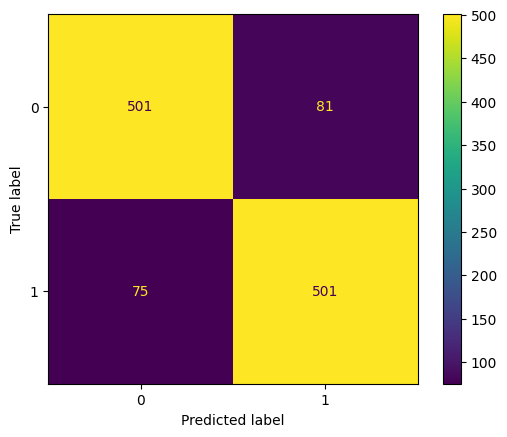

In [15]:
tn, fp, fn, tp = display_report(y_train, in_sample_preds)

In [16]:
fpr_max = fp / (tn + fp)
if fpr_max:
    fpr_max = min(fpr_max, FPR_MAX)
else:
    fpr_max = 1e-4
print(fpr_max)

0.01


In [17]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(
    pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=fpr_max
)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.71


In [18]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [19]:
pipe.score(X_test, y_test)

0.5485714285714286

              precision    recall  f1-score   support

           0       0.59      0.89      0.71       194
           1       0.62      0.22      0.33       156

    accuracy                           0.59       350
   macro avg       0.61      0.56      0.52       350
weighted avg       0.60      0.59      0.54       350



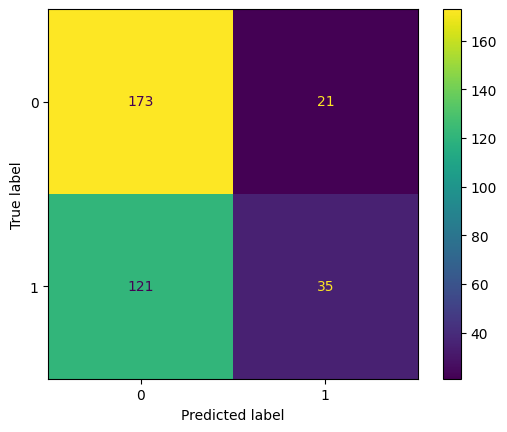

In [20]:
tn, fp, fn, tp = display_report(y_test, predictions)

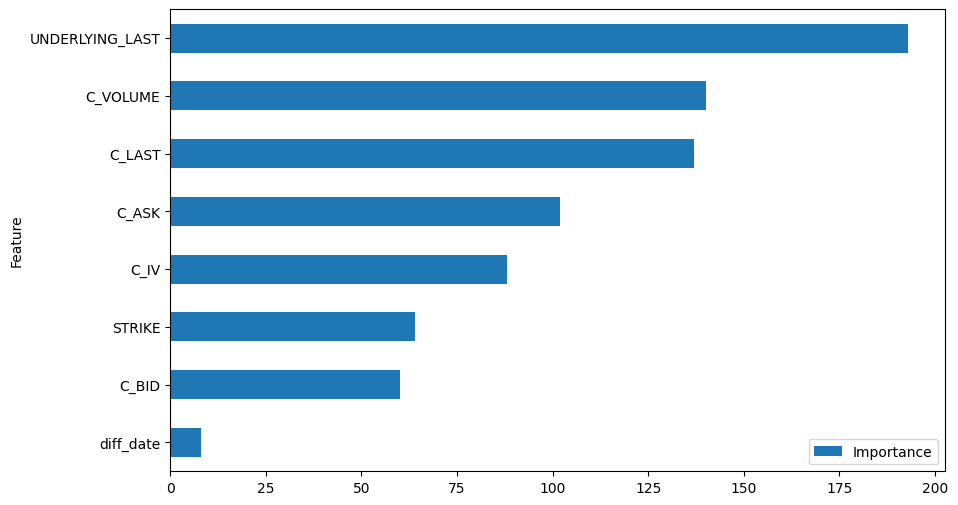

In [21]:
coefficients = pipe.named_steps["clf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [22]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_out"])

### Backtesting

In [23]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [24]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-08-12,0,427.0,7.25,2022-09-02,392.239990,0.00,-7.250000,0.000000,-7.250000
2022-08-15,0,429.0,7.18,2022-09-06,390.760010,0.00,-7.180000,0.000000,-14.430000
2022-08-16,1,430.0,6.90,2022-09-06,390.760010,-6.90,-6.900000,-6.900000,-21.330000
2022-08-17,0,426.0,7.66,2022-09-07,397.779999,0.00,-7.660000,-6.900000,-28.990000
2022-08-18,1,428.0,6.56,2022-09-07,397.779999,-6.56,-6.560000,-13.460000,-35.550000
...,...,...,...,...,...,...,...,...,...
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.00,-3.020007,204.320034,254.689880
2023-12-26,0,476.0,6.12,2024-01-19,482.429993,0.00,0.309993,204.320034,254.999873
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.00,0.239993,204.320034,255.239866


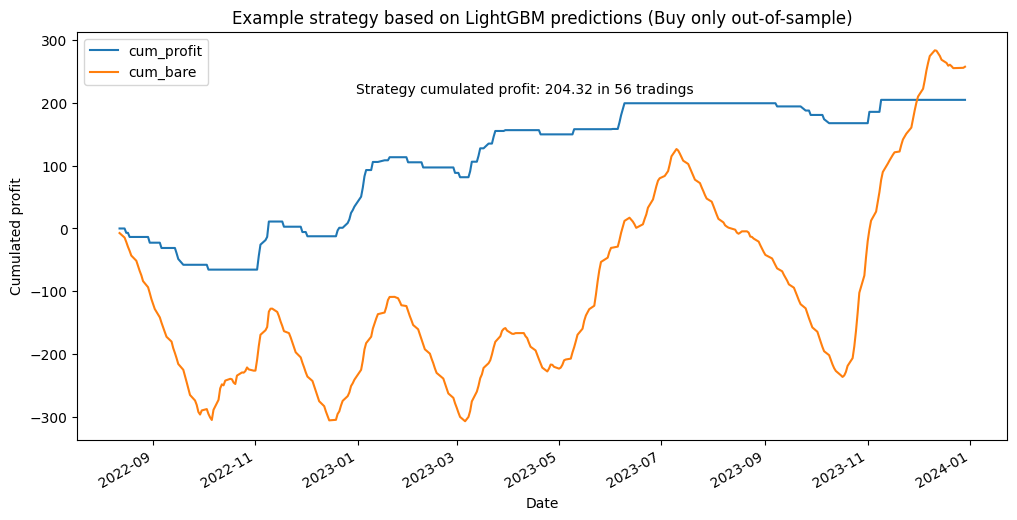

In [25]:
plot_strategy(strategy_df, "LightGBM", "(Buy only out-of-sample)")

In [26]:
compare_df["cum_profit_out"] = strategy_df["cum_profit"].values

## LightGBM with data from MC simulation and additional features

In [27]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike", "r"], axis=1),
    ),
    axis=1,
)

In [28]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### Split dataset

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df,
    target.values.flatten(),
    test_size=TEST_SIZE,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [30]:
params = tune_params(X_train, y_train, METRIC, TIMEOUT, max_iter=20, max_dep=8)

[I 2024-02-18 23:51:24,733] A new study created in memory with name: no-name-8eb4526c-badd-4943-bad9-9b6516a7fc0f
[I 2024-02-18 23:51:25,120] Trial 0 finished with value: 0.537151675136419 and parameters: {'n_estimators': 15, 'lambda_l1': 0.0026568795174116543, 'lambda_l2': 5.691357779832114, 'num_leaves': 51, 'min_sum_hessian_in_leaf': 3.06251108704905, 'feature_fraction': 0.700901728913941, 'feature_fraction_bynode': 0.40951542213203884, 'bagging_fraction': 0.4510358790928265, 'bagging_freq': 6, 'min_child_samples': 80, 'num_grad_quant_bins': 6, 'max_depth': 5, 'extra_trees': True}. Best is trial 0 with value: 0.537151675136419.
[I 2024-02-18 23:51:25,571] Trial 1 finished with value: 0.5373354437085888 and parameters: {'n_estimators': 15, 'lambda_l1': 0.001149913335423407, 'lambda_l2': 17.663118301499786, 'num_leaves': 33, 'min_sum_hessian_in_leaf': 6.191357356715355, 'feature_fraction': 0.688325844495046, 'feature_fraction_bynode': 0.39313322880424395, 'bagging_fraction': 0.4304550

Number of finished trials: 150
Best trial:
  Number: 82
  Value: 0.6990725438365016
  Params: 
    n_estimators: 15
    lambda_l1: 3.3881316291729e-07
    lambda_l2: 0.18541248949304168
    num_leaves: 112
    min_sum_hessian_in_leaf: 0.0004136049750052877
    feature_fraction: 0.6402207596256095
    feature_fraction_bynode: 0.5096225038369928
    bagging_fraction: 0.909021746447142
    bagging_freq: 6
    min_child_samples: 8
    num_grad_quant_bins: 4
    max_depth: 7
    extra_trees: False


In [31]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "clf",
            lgb.LGBMClassifier(
                **params
                | {
                    "random_state": 1968,
                    "objective": "binary",
                    "metric": METRIC,
                    "verbosity": -1,
                    "boosting_type": "gbdt",
                }
            ),
        ),
    ]
)

In [32]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('clf',
                 LGBMClassifier(bagging_fraction=0.909021746447142,
                                bagging_freq=6, extra_trees=False,
                                feature_fraction=0.6402207596256095,
                                feature_fraction_bynode=0.5096225038369928,
                                lambda_l1=3.3881316291729e-07,
                                lambda_l2=0.18541248949304168, max_depth=7,
                                metric='average_precision', min_child_samples=8,
                                min_sum_hessian_in_leaf=0.0004136049750052877,
                                n_estimators=15, num_grad_quant_bins=4,
                                num_leaves=112, objective='binary',
                                random_state=1968, verbosity=-1))])

In [33]:
# In-sample score
pipe.score(X_train, y_train)

0.8523316062176166

In [34]:
in_sample_preds = pipe.predict(X_train)

              precision    recall  f1-score   support

           0       0.90      0.79      0.84       582
           1       0.81      0.91      0.86       576

    accuracy                           0.85      1158
   macro avg       0.86      0.85      0.85      1158
weighted avg       0.86      0.85      0.85      1158



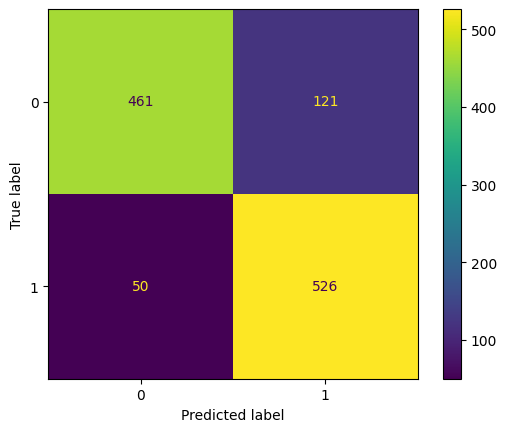

In [35]:
tn, fp, fn, tp = display_report(y_train, in_sample_preds)

In [36]:
fpr_max = fp / (tn + fp)
if fpr_max:
    fpr_max = min(fpr_max, FPR_MAX)
else:
    fpr_max = 1e-4
print(fpr_max)

0.01


In [37]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(
    pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=fpr_max
)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.65


In [38]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [39]:
pipe.score(X_test, y_test)

0.5371428571428571

              precision    recall  f1-score   support

           0       0.60      0.89      0.72       194
           1       0.67      0.27      0.38       156

    accuracy                           0.61       350
   macro avg       0.63      0.58      0.55       350
weighted avg       0.63      0.61      0.57       350



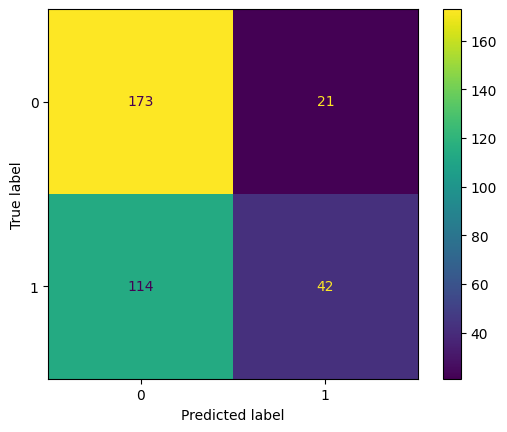

In [40]:
tn, fp, fn, tp = display_report(y_test, predictions)

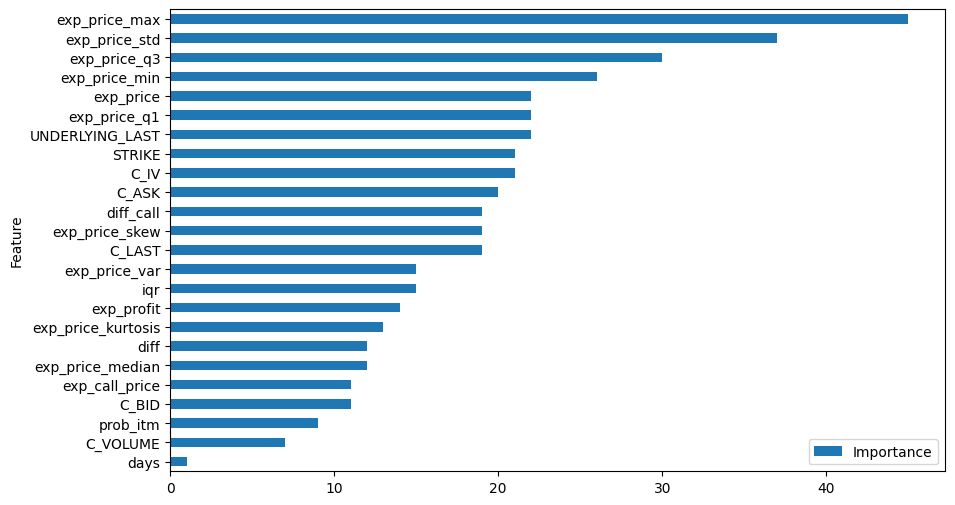

In [41]:
coefficients = pipe.named_steps["clf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [42]:
compare_df["mmar_rf_pred_out"] = predictions

### Backtesting

In [43]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [44]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-08-12,0,427.0,7.25,2022-09-02,392.239990,0.0,-7.250000,0.000000,-7.250000
2022-08-15,0,429.0,7.18,2022-09-06,390.760010,0.0,-7.180000,0.000000,-14.430000
2022-08-16,0,430.0,6.90,2022-09-06,390.760010,0.0,-6.900000,0.000000,-21.330000
2022-08-17,0,426.0,7.66,2022-09-07,397.779999,0.0,-7.660000,0.000000,-28.990000
2022-08-18,0,428.0,6.56,2022-09-07,397.779999,0.0,-6.560000,0.000000,-35.550000
...,...,...,...,...,...,...,...,...,...
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.0,-3.020007,279.539998,254.689880
2023-12-26,0,476.0,6.12,2024-01-19,482.429993,0.0,0.309993,279.539998,254.999873
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.0,0.239993,279.539998,255.239866


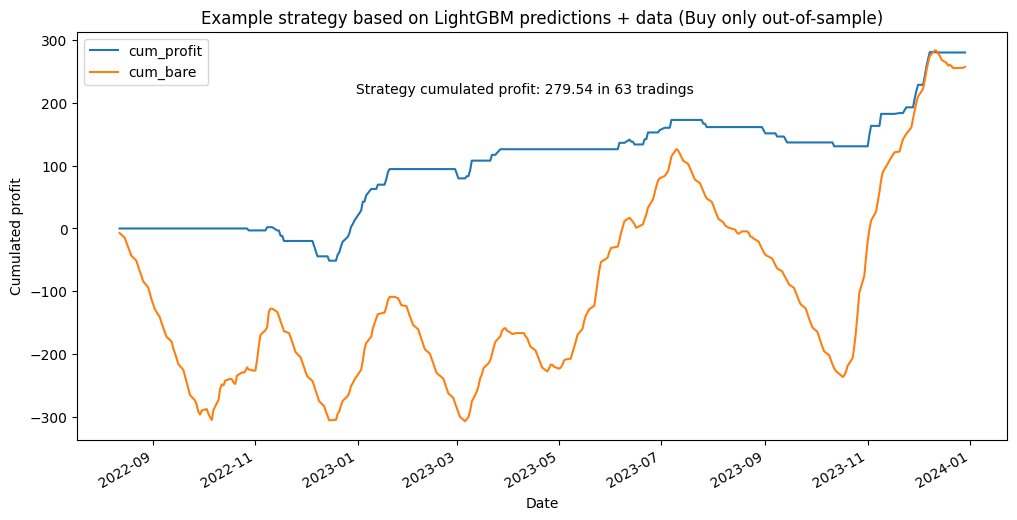

In [45]:
plot_strategy(strategy_df, "LightGBM", "+ data (Buy only out-of-sample)")

In [46]:
compare_df["mmar_cum_profit_out"] = strategy_df["cum_profit"].values
compare_df["mmar_cum_bare_out"] = strategy_df["cum_bare"].values

## Compare the two predictions

In [47]:
mask_out = (compare_df["bare_rf_pred_out"] - compare_df["mmar_rf_pred_out"]).astype(
    bool
)

In [48]:
# Compare out of sample preds
compare_df[mask_out]

,bare_rf_pred_out,cum_profit_out,mmar_rf_pred_out,mmar_cum_profit_out,mmar_cum_bare_out
2,1,-6.900000,0,0.000000,-21.330000
4,1,-13.460000,0,0.000000,-35.550000
12,1,-22.560000,0,0.000000,-102.430000
17,1,-30.960000,0,0.000000,-149.580000
24,1,-39.310000,0,0.000000,-206.100000
...,...,...,...,...,...
332,0,204.320034,1,241.709991,235.379906
333,0,204.320034,1,257.189989,250.859904
334,0,204.320034,1,269.449987,263.119901
335,0,204.320034,1,280.199984,273.869899


In [49]:
compare_df[mask_out].shape

(81, 5)

In [50]:
compare_df.sum(axis=0)

bare_rf_pred_out          56.000000
cum_profit_out         38758.828147
mmar_rf_pred_out          63.000000
mmar_cum_profit_out    35001.977073
mmar_cum_bare_out     -35888.316993
dtype: float64

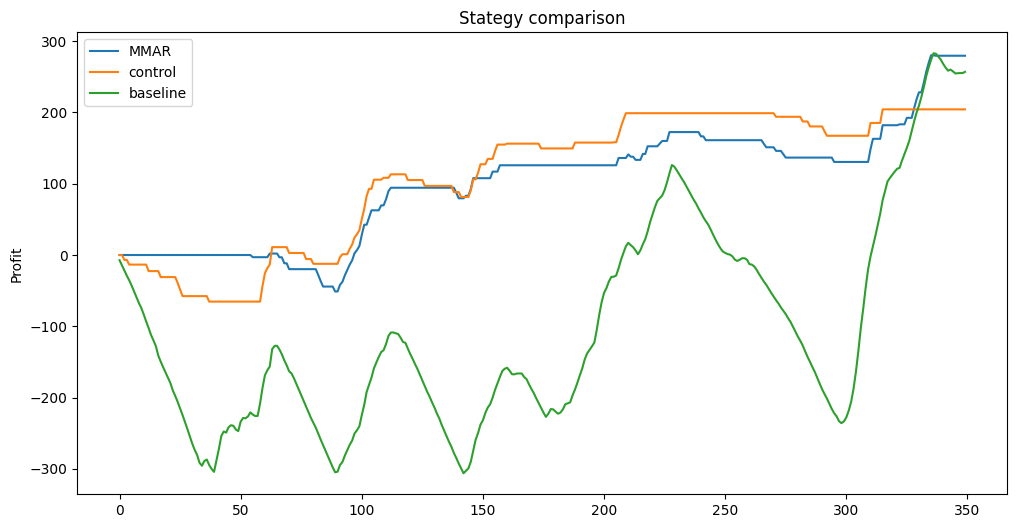

In [51]:
compare_df[["mmar_cum_profit_out", "cum_profit_out", "mmar_cum_bare_out"]].rename(
    {
        "mmar_cum_profit_out": "MMAR",
        "cum_profit_out": "control",
        "mmar_cum_bare_out": "baseline",
    },
    axis=1,
).plot(figsize=(12, 6), title="Stategy comparison", ylabel="Profit")
plt.show()